In [1]:
from utils import *
from helpers import *
import pandas as pd
from params import *
import os

### adding SG with 1 maximum minutes of delay

In [2]:
tstamp = '1003-153339'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
idle = pd.read_csv(os.path.join(RESULTS_PATH, 'idle.csv'))
pax = pd.read_csv(os.path.join(RESULTS_PATH, 'pax.csv'))
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
trips = pd.read_csv(os.path.join(RESULTS_PATH, 'trips.csv'))

In [3]:
table, table_pcts = tabulate_improvements(state, idle, pax, trips, base_scenario='DN', flex_stops=FLEX_STOPS)

<AxesSubplot: xlabel='idle_time', ylabel='Count'>

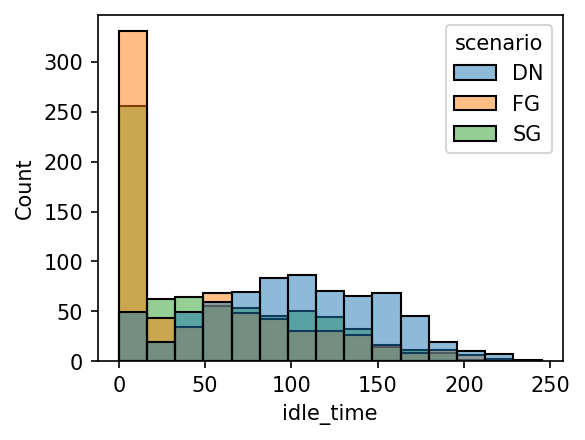

In [4]:
fig, axs = plt.subplots(figsize=(4,3))
sns.histplot(idle, x='idle_time', hue='scenario', common_norm=False)

In [7]:
table

,n_lates,idle_time,wait_time,headway_cv,load,denied_riders,fixed_ridership,flex_ridership,tot_ridership,n_trips
scenario,,,,,,,,,,
DN,23,19.61,304.0,0.087,2.26,857,3941,NaN,3941,739
FG,259,8.90,307.0,0.175,2.92,100,3901,767.0,4668,733
SG,194,10.20,303.0,0.122,2.71,253,3807,612.0,4419,736


In [8]:
table_pcts

,n_lates,idle_time,wait_time,headway_cv,load,denied_riders,fixed_ridership,flex_ridership,tot_ridership,n_trips
scenario,,,,,,,,,,
DN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,0.000,0.000
FG,1026.087,-54.615,0.987,101.149,29.204,-88.331,-1.015,NaN,18.447,-0.812
SG,743.478,-47.986,-0.329,40.230,19.912,-70.478,-3.400,NaN,12.129,-0.406


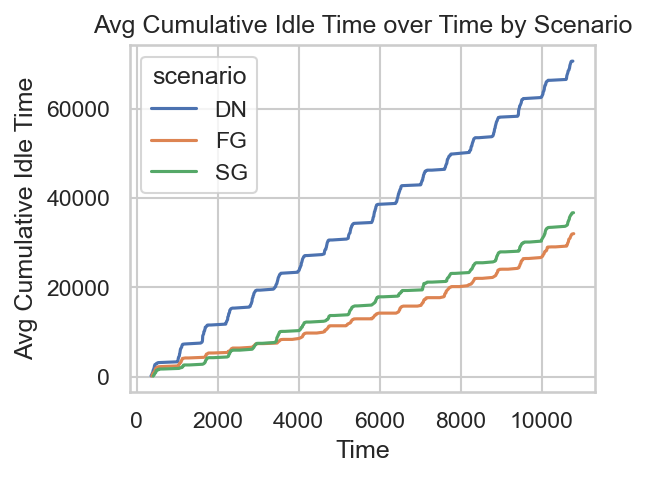

In [7]:
plot_cumulative_idle_time(idle)

## debugging

In [1]:
from objects import RouteManager, EventManager

route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

obs, reward, terminated, truncated, info = event.step(route, action=None)
# while not terminated:
#     obs, reward, terminated, truncated, info = event.step(route, action=True)

In [2]:
event.timestamps[-1]

284.0

In [11]:
pax.groupby(['origin', 'destination']).size().reset_index()

,origin,destination,0
0,0,1,847
1,0,3,1826
2,0,5,1776
3,1,3,856
4,1,5,841
5,1,6,1823
6,2,5,460
7,2,6,464
8,3,5,860
9,3,6,1808


In [15]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])

[('in', 0, 1, 6164.0)]
[('in', 2, 3, 157.0), ('in', 2, 3, 426.0), ('in', 2, 5, 1115.0), ('in', 2, 6, 1444.0), ('in', 2, 3, 1701.0), ('in', 2, 6, 2410.0), ('in', 2, 6, 2869.0), ('in', 2, 3, 3366.0)]
[('in', 3, 6, 5696.0)]
[('in', 4, 6, 280.0), ('in', 4, 5, 1974.0), ('in', 4, 6, 2670.0), ('in', 4, 6, 4121.0), ('in', 4, 6, 4718.0), ('in', 4, 5, 5348.0), ('in', 4, 6, 5610.0), ('in', 4, 6, 5662.0)]
[('in', 5, 6, 5756.0), ('in', 5, 6, 5878.0), ('in', 5, 6, 6040.0)]
[('out', 0, 1, 6008.0)]
[('out', 2, 3, 202.0), ('out', 2, 5, 893.0), ('out', 2, 6, 3028.0), ('out', 2, 6, 3718.0), ('out', 2, 3, 5718.0), ('out', 2, 6, 5863.0)]
[('out', 4, 6, 139.0), ('out', 4, 6, 1168.0), ('out', 4, 6, 2023.0), ('out', 4, 6, 2190.0), ('out', 4, 6, 2901.0), ('out', 4, 5, 3079.0), ('out', 4, 5, 3605.0), ('out', 4, 5, 4359.0), ('out', 4, 6, 4575.0), ('out', 4, 6, 5305.0), ('out', 4, 6, 5748.0)]
